In [1]:
import pandas as pd
import geopandas as gpd
import numpy as np
from glob import glob
from pathlib import Path
import re
import warnings
import matplotlib.pyplot as plt
import rasterio as rio
import xarray as xr
import rioxarray as rxr
import sys
import cartopy.crs as ccrs
import cartopy.feature as cfeature
import matplotlib.dates as mdates
import matplotlib.colors as mcolors
import matplotlib.patheffects as pe
sys.path.append('src')
# from src.non_snow_retrievals import canopy_permittivity, vegetation_phase
from src.swe_retrievals import *

warnings.simplefilter('ignore', FutureWarning)
warnings.simplefilter('ignore', RuntimeWarning)
from pandas.errors import SettingWithCopyWarning
warnings.simplefilter('ignore', SettingWithCopyWarning)
warnings.simplefilter('ignore', UserWarning)


In [9]:
def compile_timeseries(station_id, time='am'):
    sites = pd.read_csv('/pl/active/palomaki-sar/insar_swe_errors/data/snotel/fig4_sites.csv')
    site = sites.loc[sites['station_id']==station_id]
    df = pd.read_csv(f'/pl/active/palomaki-sar/insar_swe_errors/data/snotel/hourly/{station_id}_hourly_2016_2025.csv',
                    index_col=0, parse_dates=True)
    df.index = df.index.tz_convert(site['timezone'].values[0]).tz_localize(None)
    tz_adjust = 6 #if site['timezone'].values[0] == 'America/Denver' else 7
    
    
    if time == 'am':
        df_out = pd.DataFrame(df.loc[df.index.hour==6, 'SOIL MOISTURE -2IN'])
    elif time == 'pm':
        df_out = pd.DataFrame(df.loc[df.index.hour==18, 'SOIL MOISTURE -2IN'])
        
    for i in df_out.index:
        if pd.isnull(df_out.loc[i, 'SOIL MOISTURE -2IN']):
            try:
                if pd.notnull(df.loc[i-pd.to_timedelta('1h'), 'SOIL MOISTURE -2IN']):
                    df_out.loc[i, 'SOIL MOISTURE -2IN'] = df.loc[i-pd.to_timedelta('1h'), 'SOIL MOISTURE -2IN']
            except KeyError:
                pass
        if pd.isnull(df_out.loc[i, 'SOIL MOISTURE -2IN']):
            try:
                if pd.notnull(df.loc[i+pd.to_timedelta('1h'), 'SOIL MOISTURE -2IN']):
                    df_out.loc[i, 'SOIL MOISTURE -2IN'] = df.loc[i+pd.to_timedelta('1h'), 'SOIL MOISTURE -2IN']
            except KeyError:
                pass
        
    # Keep temp, swe, SM columns from snotel data
    if df.iloc[0]['AIR TEMP_units'] == 'degF':
        df_out['airtemp_C'] = (df.loc[df_out.index, 'AIR TEMP'] - 32)*5/9
    else:
        df_out['airtemp_C'] = df.loc[df_out.index, 'AIR TEMP']
    
    df_out['swe_m'] = df.loc[df_out.index, 'SWE'] * 0.0254
    df_out.rename(columns={'SOIL MOISTURE -2IN':'soil_moisture_pct'}, inplace=True)
    
    
    # Dry atmosphere
    dry_atmo = xr.open_dataset(f'/pl/active/palomaki-sar/insar_swe_errors/data/atmo_dry/pressure_{time}.nc').sel(lat=site['lat'].values[0], lon=site['lon'].values[0], method='nearest')
    dry_atmo['time'] = dry_atmo['time'] - pd.to_timedelta(tz_adjust, 'h')
    df_out['surf_pres'] = dry_atmo.to_dataframe()['PS']
    
    # Wet atmosphere
    wet_atmo = xr.open_dataset(f'/pl/active/palomaki-sar/insar_swe_errors/data/atmo_wet/pw_{time}.nc').sel(lat=site['lat'].values[0], lon=site['lon'].values[0], method='nearest')
    wet_atmo['time'] = wet_atmo['time'] - pd.to_timedelta(tz_adjust, 'h')
    df_out['precip_water'] = wet_atmo.to_dataframe()['TQV']
    
    # Ionosphere
    ion = xr.open_dataset(f'/pl/active/palomaki-sar/insar_swe_errors/data/ionosphere/ion_{time}.nc').sel(y=site['lat'].values[0], x=site['lon'].values[0], method='nearest')
    # Ionosphere data is saved at the correct local hour for am/pm but does not have hour attached
    # Add hour into timestamp (instead of subtracting from UTC)
    if time == 'am':
        timedelta = 6
    elif time == 'pm':
        timedelta = 18
    ion['time'] = ion['time'] + pd.to_timedelta(timedelta, 'h')
    df_out['ion_tec'] = ion.to_dataframe()['__xarray_dataarray_variable__']
    
    # GNSS - only one daily value, add to both AM/PM data
    # Need to add timedelta to index calculated above
    try:
        gnss = pd.read_csv(f'/pl/active/palomaki-sar/insar_swe_errors/data/gnss/raw/{station_id}.tenv3', delim_whitespace=True, index_col=1, parse_dates=True, date_format='%y%b%d')
        gnss.index += pd.to_timedelta(timedelta, 'h')
        df_out[['gnss_east','gnss_north','gnss_up']] = gnss[['__east(m)','_north(m)','____up(m)']]
    except FileNotFoundError:
        df_out[['gnss_east','gnss_north','gnss_up']] = np.nan
    
    return df_out
    

sites = pd.read_csv('/pl/active/palomaki-sar/insar_swe_errors/data/snotel/fig4_sites.csv')
for station in sites['station_id']:
    for time in ['am','pm']:
        data = compile_timeseries(station, time=time)
        data.to_csv(f'/pl/active/palomaki-sar/insar_swe_errors/data/compiled/{station}_{time}.csv')

## Figure 1 - SWE curves and error comparison

In [3]:
def calc_all_errors(df, site):
    # Calculate errors from pre-compiled data
    # Soil moisture
    df['swe_change'] = df['swe_m'].diff(periods=12)
    df['soil_error'] = calc_soil_moisture_error(sand=site['sand']/10, 
                                                clay=site['clay']/10, 
                                                sm_series=df['soil_moisture_pct']/100)
    # Veg permittivity changes
    df['veg_error'] = calc_veg_permittivity_error(canopy_height=site['canopy_height'].values[0], 
                                                  temperature_series=df['airtemp_C'])
    # Dry atmosphere
    df['dry_atmo_error'] = calc_dry_atmo_error(pressure_series=df['surf_pres'])
    # Wet atmosphere
    df['wet_atmo_error'] = calc_wet_atmo_error(pw_series=df['precip_water']/1000)
    # Ionosphere
    df['ion_error'] = calc_ionosphere_error(tec_series=df['ion_tec'])
    # Surface deformation
    df['defo_error'] = calc_deformation_error(defo_series=df['gnss_up'])
    
    # Total error
    df['total_error'] = df[['soil_error','veg_error','dry_atmo_error','wet_atmo_error','defo_error','ion_error']].sum(axis=1,min_count=1)
    df['non_ion_error'] = df[['soil_error','veg_error','dry_atmo_error','wet_atmo_error','defo_error']].sum(axis=1,min_count=1)
    
    return df    


def plot_swe_curves(station_id: int, wateryear: int, time: str = 'am', ax1=None,
                    ax2=None, plot_type: str = 'total_error', extra_title_text = '', 
                    return_data: bool = True):
    """
    679	Paradise
    398	Clackamas Lake
    1000	Annie Springs
    846	Virginia Lakes Rdg
    821	Tipton
    759	Silvies
    417	Corral Canyon
    803	Sunset
    490	Galena Summit
    577	Lewis Lake Divide
    828	Trial Lake
    935	Jackwhacker Gulch
    708	Quemazon
    """
    sites = pd.read_csv('/pl/active/palomaki-sar/insar_swe_errors/data/snotel/fig4_sites.csv')
    site = sites.loc[sites['station_id']==station_id]
    df = pd.read_csv(f'/pl/active/palomaki-sar/insar_swe_errors/data/compiled/{station_id}_{time}.csv',
                     index_col=0, parse_dates=True)
    # Subset for water year
    df['wateryear'] = [i.year + 1 if i.month in [10,11,12] else i.year for i in df.index]
    df = df.loc[df['wateryear']==wateryear]
    df = df.loc[:f'{wateryear}-07-01']
    
    df = calc_all_errors(df, site)
    
    if plot_type == 'total_error':
        # Total error plot
        df['swe_m'].plot(ax=ax1, lw=1.5, label='SNOTEL SWE')
        (df['non_ion_error'] + df['swe_m']).plot(ax=ax1, label='SWE + non-ion errors')
        (df['total_error'] + df['swe_m']).plot(ax=ax1, color='k', alpha=0.5, lw=0.7, label='SWE + all errors')
        
        ax1.set_title(f'{site["station_name"].values[0]} {wateryear}  (Peak SWE = {df["swe_m"].max():.2f} m){extra_title_text}', linespacing=1.6)
        ax1.set_xlabel('')
        ax1.set_ylabel('SWE [m]')
        ax1.xaxis.set_major_locator(mdates.MonthLocator())
        ax1.xaxis.set_major_formatter(mdates.DateFormatter('%b'))
        ax1.set_xticklabels(ax1.get_xticklabels(), rotation=0, ha='center')
        leg = ax1.legend(fontsize=9, loc='upper left')
        for legobj in leg.legend_handles:
            legobj.set_linewidth(2.0)
        
        # Error components
        percent_error = pd.DataFrame(index=df.index)
        relative_swe_column = 'swe_m'    # 'swe_m' or 'swe_change'
        for c in ['soil_error','veg_error','dry_atmo_error','wet_atmo_error','ion_error','defo_error']:
#             percent_error[c] = df[c]/df['swe_m']*100
            percent_error[c] = df[c]/df[relative_swe_column]*100
            
        percent_error.loc[df[relative_swe_column] < 0.1] = np.nan
        percent_error['defo_error'].plot(ax=ax2, label='Surface deformation')
        percent_error['soil_error'].plot(ax=ax2, label='Soil permittivity')
        percent_error['veg_error'].plot(ax=ax2, label='Veg permittivity')
        percent_error['dry_atmo_error'].plot(ax=ax2, label='Dry atmosphere', alpha=0.5, lw=0.8, color='k')
        percent_error['wet_atmo_error'].plot(ax=ax2, label='Wet atmosphere', alpha=0.6, lw=0.8, color=plt.get_cmap('tab10')(3))
        
#         df['defo_error'].plot(ax=ax2, label='Surface deformation')
#         df['soil_error'].plot(ax=ax2, label='Soil moisture')
#         df['veg_error'].plot(ax=ax2, label='Veg permittivity')
#         df['dry_atmo_error'].plot(ax=ax2, label='Dry atmosphere', alpha=0.5, lw=0.8, color='k')
#         df['wet_atmo_error'].plot(ax=ax2, label='Wet atmosphere', alpha=0.3, lw=0.8, color='k')
        
#         percent_error['ion_error'].plot(ax=ax2, label='Ionosphere')
#         ax.set_title(f'{site["station_name"].values[0]} {wateryear}')

        ax2.hlines([-10,10], f'{wateryear-1}-10-01', f'{wateryear}-07-01', lw=1.5, color='k', ls='--')
        
        ax2.set_title(f'{site["station_name"].values[0]} {wateryear}{extra_title_text}', linespacing=1.6)
        ax2.set_xlabel('')
        ax2.set_xlim(ax1.get_xlim())
        ax2.xaxis.set_major_locator(mdates.MonthLocator())
        ax2.xaxis.set_major_formatter(mdates.DateFormatter('%b'))
        ax2.set_xticklabels(ax2.get_xticklabels(), rotation=0, ha='center')
#         ax2.set_ylim([-100,50])
        ax2.set_ylabel('Error [% of measured SWE]')
        leg2 = ax2.legend(fontsize=9)
        for legobj in leg2.legend_handles:
            legobj.set_linewidth(2.0)
        
    elif plot_type == 'individual':
        if ax1 is None:
            fig, ax1 = plt.subplots(figsize=(6,6))
        
#         df['swe_m'].plot(ax=ax1, label='SNOTEL')
        (df['dry_atmo_error'] + df['swe_m']).plot(ax=ax1, label='Dry atmosphere', alpha=0.6)
        (df['wet_atmo_error'] + df['swe_m']).plot(ax=ax1, label='Wet atmosphere', alpha=0.6)
        (df['soil_error'] + df['swe_m']).plot(ax=ax1, label='Soil permittivity')
        (df['veg_error'] + df['swe_m']).plot(ax=ax1, label='Veg permittivity')
        (df['defo_error'] + df['swe_m']).plot(ax=ax1, label='Surface deformation')
        
        
#         (df['ion_error'] + df['swe_m']).plot(ax=ax1, label='Ionosphere')
    
        ax1.set_title(f'{site["station_name"].values[0]} WY{wateryear}')
        ax1.set_xlabel('')
        ax1.set_ylabel('SWE [m]')
        ax1.legend(fontsize=9, loc='upper right')
    
    if return_data:
        return df


# for axx in ax.flatten():
#     axx.set_ylim([-0.02, 1.02]

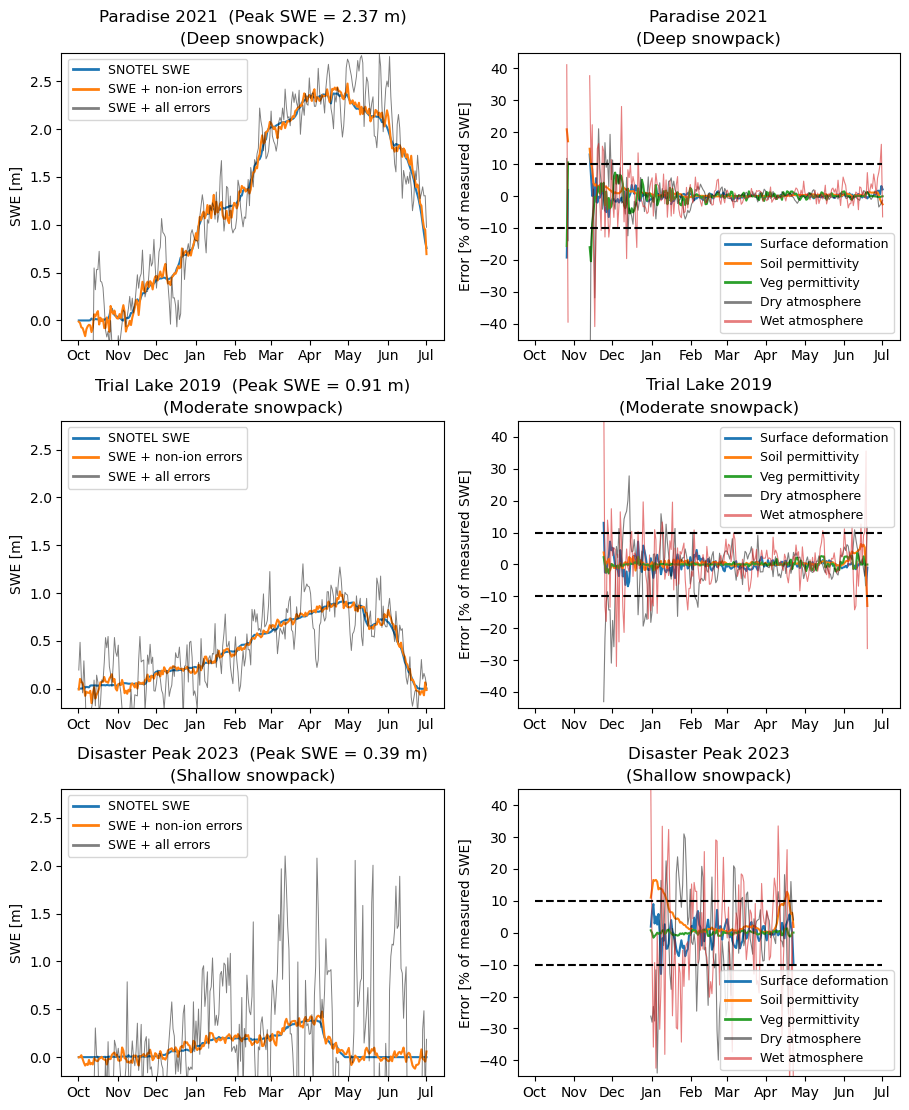

In [4]:
sites = pd.read_csv('/pl/active/palomaki-sar/insar_swe_errors/data/snotel/fig4_sites.csv').dropna(subset='ecoregion')
# site = sites.loc[sites['station_id']==station_id]

fig, ax = plt.subplots(3, 2, figsize=(11.5*0.8,14*0.8))#, gridspec_kw={'wspace':0.4,'hspace':0.3})
palisades = plot_swe_curves(station_id=679, wateryear=2021, ax1=ax[0,0], ax2=ax[0,1], extra_title_text='\n(Deep snowpack)', return_data=True)
trial = plot_swe_curves(station_id=828, wateryear=2019, ax1=ax[1,0], ax2=ax[1,1], extra_title_text='\n(Moderate snowpack)', return_data=True) #828 2017
disaster = plot_swe_curves(station_id=445, wateryear=2023, ax1=ax[2,0], ax2=ax[2,1], extra_title_text='\n(Shallow snowpack)', return_data=True)
ymin = min([ax.get_ylim()[0] for ax in ax[0]])
ymax = max([ax.get_ylim()[1] for ax in ax[0]])
for axx in ax[:,0]:
    axx.set_ylim([-0.2, 2.8])
for axx in ax[:,1]:
    axx.set_ylim([-45, 45])
    
# plt.tight_layout()
# fig.savefig('local/figs/fig1_with_ion.png', dpi=300)
# plt.show()



# for s_id in sites['station_id']:
#     fig, ax = plt.subplots(2, 5, figsize=(20,8))
#     for i, year in enumerate(range(2016,2026)):
#         plot_swe_curves(station_id=s_id, wateryear=year, plot_type='individual', ax1=ax.flatten()[i], return_data=False)
    
#     plt.tight_layout()
#     fig.savefig(f'local/figs/individual_sites/{s_id}_allyears.png', dpi=300)
#     plt.close()
    
plt.tight_layout()
# fig.savefig('local/figs/fig1.png', dpi=300)

## Potential Figure 2 showing ionosphere errors

In [ ]:
sites = pd.read_csv('/pl/active/palomaki-sar/insar_swe_errors/data/snotel/fig4_sites.csv')
station_id = 784
wateryear = 2023
site = sites.loc[sites['station_id']==station_id]

fig, ax = plt.subplots(2,2)
df = plot_swe_curves(station_id=station_id, wateryear=wateryear, ax1=ax[1,0], ax2=ax[1,1], return_data=True)
plt.close()

fig, ax1 = plt.subplots(figsize=(6,6))
df['swe_m'].plot(ax=ax1, lw=1.5, label='SNOTEL')
(df['non_ion_error'] + df['swe_m']).plot(ax=ax1, label='SNOTEL + non-ion errors')
(df['total_error'] + df['swe_m']).plot(ax=ax1, color='k', alpha=0.6, lw=1, label='SNOTEL + all errors')


ax1.set_title(f'{site["station_name"].values[0]} WY{wateryear}')
ax1.set_xlabel('')
ax1.set_ylabel('SWE [m]')
ax1.xaxis.set_major_locator(mdates.MonthLocator())
ax1.xaxis.set_major_formatter(mdates.DateFormatter('%b'))
ax1.set_xticklabels(ax1.get_xticklabels(), rotation=0, ha='center')
ax1.legend()
fig.savefig('local/figs/fig2_ion_error.png', dpi=300)

## Figure 2 - Temporal variability

In [20]:
dswe_thresh = 0.0001
extra_title_dict = {'Paradise':' (Deep snowpack)','Trial Lake':' (Moderate snowpack)','Disaster Peak':' (Shallow snowpack)'}

def make_temp_var_plot(ax, df_am, df_pm, error_col, site, n_wy_days=274, plot_pm=False, shade=True):
    c = error_col
    plot_titles = {'defo_error':'Surface deformation error','soil_error':'Soil permittivity error','veg_error':'Veg permittivity error','dry_atmo_error':'Dry atmosphere error','wet_atmo_error':'Wet atmosphere error','ion_error':'Ionospheric error'}
    am_gb = df_am.loc[df_am['dowy']<=n_wy_days].groupby('dowy')
    pm_gb = df_pm.loc[df_pm['dowy']<=n_wy_days].groupby('dowy')

    month_starts = [1,32,62,93,124,152,183,213,244,274] # Through July

#     ax.fill_between(am_gb.quantile(0.1)[c].index, df_am.loc[df_am['dowy']<=n_wy_days].groupby('dowy').quantile(0.1)[c].rolling(7).mean(), df_am.loc[df_am['dowy']<=n_wy_days].groupby('dowy').quantile(0.9)[c].rolling(7).mean(), alpha=0.4, color=plt.get_cmap('tab10')(0), label='AM orbit', zorder=10)
#     ax.plot(am_gb.median()[c].rolling(7).mean(), lw=2, zorder=11)
#     ax.plot(am_gb.quantile(0.1)[c].rolling(7).mean(), lw=1, alpha=0.8, color=plt.get_cmap('tab10')(0), zorder=12)
#     ax.plot(am_gb.quantile(0.9)[c].rolling(7).mean(), lw=1, alpha=0.8, color=plt.get_cmap('tab10')(0), zorder=13)
#     ax.plot(am_gb.median()['swe_change'].rolling(7).mean(), lw=2, zorder=14, color='k')

    median_swe_change = am_gb.median()['swe_change'].rolling(7).mean()
    median_swe_change.loc[median_swe_change < dswe_thresh] = np.nan
    min_ = am_gb.min()[c].rolling(7).mean() / median_swe_change * 100
    max_ = am_gb.max()[c].rolling(7).mean() / median_swe_change * 100
    median = am_gb.median()[c].rolling(7).mean() / median_swe_change * 100
    ax.plot(median, lw=2, zorder=11, label='AM orbit')
    if shade:
        ax.fill_between(min_.index, min_, max_, alpha=0.4, color=plt.get_cmap('tab10')(0), zorder=10)
        ax.plot(min_, lw=1, alpha=0.8, color=plt.get_cmap('tab10')(0), zorder=12)
        ax.plot(max_, lw=1, alpha=0.8, color=plt.get_cmap('tab10')(0), zorder=13)


    
    if plot_pm:   
#         ax.fill_between(pm_gb.quantile(0.1)[c].index, df_pm.loc[df_pm['dowy']<=n_wy_days].groupby('dowy').quantile(0.1)[c].rolling(7).mean(), df_pm.loc[df_pm['dowy']<=n_wy_days].groupby('dowy').quantile(0.9)[c].rolling(7).mean(), alpha=0.5, color=plt.get_cmap('tab10')(1), label='PM orbit', zorder=0)
#         ax.plot(pm_gb.median()[c].rolling(7).mean(), lw=2, color=plt.get_cmap('tab10')(1), zorder=1)
#         ax.plot(pm_gb.quantile(0.1)[c].rolling(7).mean(), lw=1, alpha=0.8, color=plt.get_cmap('tab10')(1), zorder=2)
#         ax.plot(pm_gb.quantile(0.9)[c].rolling(7).mean(), lw=1, alpha=0.8, color=plt.get_cmap('tab10')(1), zorder=3)
#         ax.legend(ncol=2, fontsize=9, loc='upper right')
        
        median_swe_change = pm_gb.median()['swe_change'].rolling(7).mean()
        median_swe_change.loc[median_swe_change < dswe_thresh] = np.nan
        min_ = pm_gb.min()[c].rolling(7).mean() / median_swe_change * 100
        max_ = pm_gb.max()[c].rolling(7).mean() / median_swe_change * 100
        median = pm_gb.median()[c].rolling(7).mean() / median_swe_change * 100
        ax.plot(median, lw=2, zorder=1, label='PM orbit')
        if shade:
            ax.fill_between(min_.index, min_, max_, alpha=0.4, color=plt.get_cmap('tab10')(1), zorder=0)
            ax.plot(min_, lw=1, alpha=0.8, color=plt.get_cmap('tab10')(1), zorder=2)
            ax.plot(max_, lw=1, alpha=0.8, color=plt.get_cmap('tab10')(1), zorder=3)
        leg = ax.legend(ncol=2, fontsize=9, loc='lower right')
        leg.set_zorder(100)
    
    ax.set_xticks(month_starts)
    ax.set_xticklabels(['Oct','Nov','Dec','Jan','Feb','Mar','Apr','May','Jun','Jul'])
    if c == 'defo_error':
        st_name = site['station_name'].values[0]
        ax.set_title(st_name + f'{extra_title_dict[st_name]}\n\n' + plot_titles[c])
    else:
        ax.set_title(plot_titles[c])


def plot_temporal_variability(station_id: int, ax: plt.axes = None, return_data: bool = True):
    """
    679	Paradise
    398	Clackamas Lake
    1000	Annie Springs
    846	Virginia Lakes Rdg
    821	Tipton
    759	Silvies
    417	Corral Canyon
    803	Sunset
    490	Galena Summit
    577	Lewis Lake Divide
    828	Trial Lake
    935	Jackwhacker Gulch
    708	Quemazon
    """
    sites = pd.read_csv('/pl/active/palomaki-sar/insar_swe_errors/data/snotel/fig4_sites.csv')
    site = sites.loc[sites['station_id']==station_id]
    df_am = pd.read_csv(f'/pl/active/palomaki-sar/insar_swe_errors/data/compiled/{station_id}_am.csv',
                     index_col=0, parse_dates=True)
    df_pm = pd.read_csv(f'/pl/active/palomaki-sar/insar_swe_errors/data/compiled/{station_id}_pm.csv',
                     index_col=0, parse_dates=True)
    
    df_am = calc_all_errors(df_am, site)
    df_pm = calc_all_errors(df_pm, site)
    
    
    for df in [df_am, df_pm]:
    # Subset for water year
        df['wateryear'] = [i.year + 1 if i.month in [10,11,12] else i.year for i in df.index]
        df['dowy'] = [(r[0] - pd.to_datetime(f'{int(r[1]["wateryear"])-1}-10-01')) for r in df.iterrows()] # type: ignore
        df['dowy'] = df['dowy'].dt.days + 1


    # Plot
    if ax is None:
        fig, ax = plt.subplots(6, 1, figsize=(5,20))
    error_cols = ['defo_error','soil_error','veg_error','dry_atmo_error','wet_atmo_error','ion_error']
    for i, c in enumerate(error_cols):
        if c == 'ion_error':
            make_temp_var_plot(ax[i], df_am, df_pm, c, site, plot_pm=True, shade=True)
        else:
            make_temp_var_plot(ax[i], df_am, df_pm, c, site, plot_pm=False)
        
        
    if return_data:
        return (df_am, df_pm)





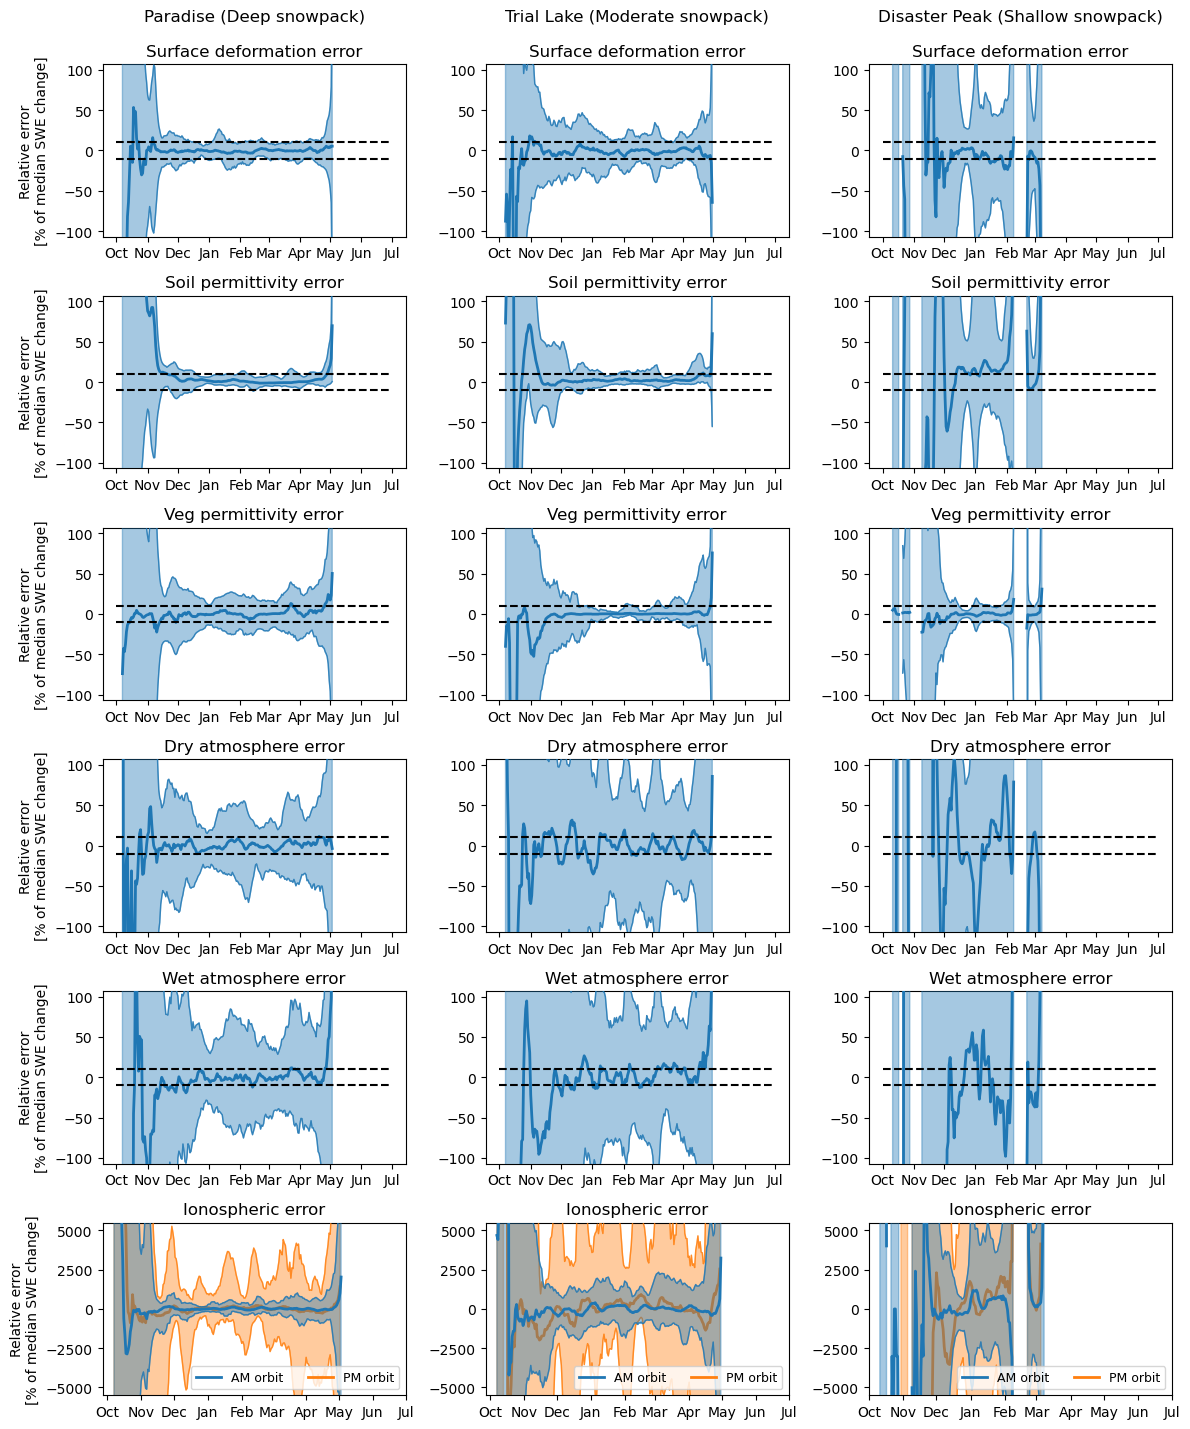

In [21]:
fig, ax = plt.subplots(6, 3, figsize=(15*0.8,24*0.6))
plot_temporal_variability(station_id=679, ax=ax[:,0], return_data=False)
plot_temporal_variability(station_id=828, ax=ax[:,1], return_data=False)
plot_temporal_variability(station_id=445, ax=ax[:,2], return_data=False)

for i in range(6):
    for axx in ax[i]:
        if i != 5:
            axx.set_ylim(-107, 107)
            axx.hlines([-10,10], 1, 274, lw=1.5, color='k', ls='--', zorder=100)
        else:
#             axx.set_ylim(-856, 856)
#             axx.set_yticks(np.arange(-800,801,400))
            axx.set_ylim(-5500, 5500)
            axx.set_yticks(np.arange(-5000,5001,2500))

# for axx in ax[5,:]:
#     axx.hlines([-0.08,0.08], 1, 274, lw=1.5, color='k', ls='--', zorder=100)
# for i in range(6):
#     for axx in ax[i]:
#         if i != 5:
#             axx.set_ylim(-0.081, 0.081)
        
#         else:
#             axx.set_ylim(-4.5, 4.5)
        
#     miny = min([a.get_ylim()[0] for a in ax[i]])
#     maxy = max([a.get_ylim()[1] for a in ax[i]])
#     for axx in ax[i]: 
#         axx.set_ylim(miny, maxy)

for axx in ax[:,0]:
    axx.set_ylabel('Relative error\n[% of median SWE change]', fontsize=10)

# ax[5,0].set_ylabel('Error [% of median SWE change]', fontsize=10, labelpad=19)

plt.tight_layout()


In [22]:
# leg0 = ax[5,0].legend(ncol=2, fontsize=9, loc='lower right')
# leg1 = ax[5,1].legend(ncol=2, fontsize=9, loc='lower right')
# leg2 = ax[5,2].legend(ncol=2, fontsize=9, loc='lower right')

# for leg in [leg0, leg1, leg2]:
#     leg.set_zorder(100)
# fig

# for axx in ax[5]:
#     axx.set_ylim(-5500, 5500)
#     axx.set_yticks(np.arange(-5000,5001,2500))
# fig


fig.savefig(f'local/figs/fig2_{dswe_thresh:.4f}_thresh.png', dpi=300)

## Calculate median error for all types at all sites

In [19]:
sites = gpd.read_file('/pl/active/palomaki-sar/insar_swe_errors/data/snotel/fig4_sites.csv').dropna(subset='ecoregion')
for c in ['station_id','lat', 'lon', 'sand', 'clay','sturm', 'landfire', 'canopy_height']:
    sites[c] = pd.to_numeric(sites[c])
sites['median_peak_swe'] = np.nan
sites['median_soil_error'] = np.nan
sites['median_veg_error'] = np.nan
sites['median_wet_error'] = np.nan
sites['median_dry_error'] = np.nan
sites['median_ion_error'] = np.nan

sites['std_peak_swe'] = np.nan
sites['std_swe_change'] = np.nan
sites['std_soil_error'] = np.nan
sites['std_veg_error'] = np.nan
sites['std_wet_error'] = np.nan
sites['std_dry_error'] = np.nan
sites['std_ion_error'] = np.nan

sites['min_peak_swe'] = np.nan
sites['min_swe_change'] = np.nan
sites['min_soil_error'] = np.nan
sites['min_veg_error'] = np.nan
sites['min_wet_error'] = np.nan
sites['min_dry_error'] = np.nan
sites['min_ion_error'] = np.nan

sites['max_peak_swe'] = np.nan
sites['max_swe_change'] = np.nan
sites['max_soil_error'] = np.nan
sites['max_veg_error'] = np.nan
sites['max_wet_error'] = np.nan
sites['max_dry_error'] = np.nan
sites['max_ion_error'] = np.nan



for station_id in sites['station_id']:
    site = sites.loc[sites['station_id']==station_id]
    df = pd.read_csv(f'/pl/active/palomaki-sar/insar_swe_errors/data/compiled/{station_id}_am.csv',
                     index_col=0, parse_dates=True)
    df['wateryear'] = [i.year + 1 if i.month in [10,11,12] else i.year for i in df.index]

    df = calc_all_errors(df, site)
    df.loc[df['swe_change']<=0] = np.nan
    df.dropna(subset='swe_change', inplace=True)
#     for c in ['defo_error','soil_error','veg_error','dry_atmo_error','wet_atmo_error','ion_error']:
#         df[c] = df[c].abs()
    
    sites.loc[sites['station_id']==station_id, 'median_peak_swe'] = float(df[['wateryear','swe_m']].groupby('wateryear').max().median()['swe_m'])
    sites.loc[sites['station_id']==station_id, 'median_swe_change'] = float(df[['wateryear','swe_change']].groupby('wateryear').median().median()['swe_change'])
    sites.loc[sites['station_id']==station_id, 'median_defo_error'] = float(df[['wateryear','defo_error']].groupby('wateryear').median().median()['defo_error'])
    sites.loc[sites['station_id']==station_id, 'median_soil_error'] = float(df[['wateryear','soil_error']].groupby('wateryear').median().median()['soil_error'])
    sites.loc[sites['station_id']==station_id, 'median_veg_error'] = float(df[['wateryear','veg_error']].groupby('wateryear').median().median()['veg_error'])
    sites.loc[sites['station_id']==station_id, 'median_dry_error'] = float(df[['wateryear','dry_atmo_error']].groupby('wateryear').median().median()['dry_atmo_error'])
    sites.loc[sites['station_id']==station_id, 'median_wet_error'] = float(df[['wateryear','wet_atmo_error']].groupby('wateryear').median().median()['wet_atmo_error'])
    sites.loc[sites['station_id']==station_id, 'median_ion_error'] = float(df[['wateryear','ion_error']].groupby('wateryear').median().median()['ion_error'])
    
    sites.loc[sites['station_id']==station_id, 'std_peak_swe'] = float(df[['wateryear','swe_m']].groupby('wateryear').max().std()['swe_m'])
    sites.loc[sites['station_id']==station_id, 'std_swe_change'] = float(df[['wateryear','swe_change']].groupby('wateryear').std().median()['swe_change'])
    sites.loc[sites['station_id']==station_id, 'std_defo_error'] = float(df[['wateryear','defo_error']].groupby('wateryear').std().median()['defo_error'])
    sites.loc[sites['station_id']==station_id, 'std_soil_error'] = float(df[['wateryear','soil_error']].groupby('wateryear').std().median()['soil_error'])
    sites.loc[sites['station_id']==station_id, 'std_veg_error'] = float(df[['wateryear','veg_error']].groupby('wateryear').std().median()['veg_error'])
    sites.loc[sites['station_id']==station_id, 'std_dry_error'] = float(df[['wateryear','dry_atmo_error']].groupby('wateryear').std().median()['dry_atmo_error'])
    sites.loc[sites['station_id']==station_id, 'std_wet_error'] = float(df[['wateryear','wet_atmo_error']].groupby('wateryear').std().median()['wet_atmo_error'])
    sites.loc[sites['station_id']==station_id, 'std_ion_error'] = float(df[['wateryear','ion_error']].groupby('wateryear').std().median()['ion_error'])
    
    sites.loc[sites['station_id']==station_id, 'min_peak_swe'] = float(df[['wateryear','swe_m']].groupby('wateryear').max().min()['swe_m'])
    sites.loc[sites['station_id']==station_id, 'min_swe_change'] = float(df[['wateryear','swe_change']].groupby('wateryear').min().median()['swe_change'])
    sites.loc[sites['station_id']==station_id, 'min_defo_error'] = float(df[['wateryear','defo_error']].groupby('wateryear').min().median()['defo_error'])
    sites.loc[sites['station_id']==station_id, 'min_soil_error'] = float(df[['wateryear','soil_error']].groupby('wateryear').min().median()['soil_error'])
    sites.loc[sites['station_id']==station_id, 'min_veg_error'] = float(df[['wateryear','veg_error']].groupby('wateryear').min().median()['veg_error'])
    sites.loc[sites['station_id']==station_id, 'min_dry_error'] = float(df[['wateryear','dry_atmo_error']].groupby('wateryear').min().median()['dry_atmo_error'])
    sites.loc[sites['station_id']==station_id, 'min_wet_error'] = float(df[['wateryear','wet_atmo_error']].groupby('wateryear').min().median()['wet_atmo_error'])
    sites.loc[sites['station_id']==station_id, 'min_ion_error'] = float(df[['wateryear','ion_error']].groupby('wateryear').min().median()['ion_error'])
    
    sites.loc[sites['station_id']==station_id, 'max_peak_swe'] = float(df[['wateryear','swe_m']].groupby('wateryear').max().max()['swe_m'])
    sites.loc[sites['station_id']==station_id, 'max_swe_change'] = float(df[['wateryear','swe_change']].groupby('wateryear').max().median()['swe_change'])
    sites.loc[sites['station_id']==station_id, 'max_defo_error'] = float(df[['wateryear','defo_error']].groupby('wateryear').max().median()['defo_error'])
    sites.loc[sites['station_id']==station_id, 'max_soil_error'] = float(df[['wateryear','soil_error']].groupby('wateryear').max().median()['soil_error'])
    sites.loc[sites['station_id']==station_id, 'max_veg_error'] = float(df[['wateryear','veg_error']].groupby('wateryear').max().median()['veg_error'])
    sites.loc[sites['station_id']==station_id, 'max_dry_error'] = float(df[['wateryear','dry_atmo_error']].groupby('wateryear').max().median()['dry_atmo_error'])
    sites.loc[sites['station_id']==station_id, 'max_wet_error'] = float(df[['wateryear','wet_atmo_error']].groupby('wateryear').max().median()['wet_atmo_error'])
    sites.loc[sites['station_id']==station_id, 'max_ion_error'] = float(df[['wateryear','ion_error']].groupby('wateryear').max().median()['ion_error'])
    
    

sites.drop(columns=['geometry'], inplace=True)
sites.to_csv('local/median_errors_accum_only_nonabs.csv', index=False)

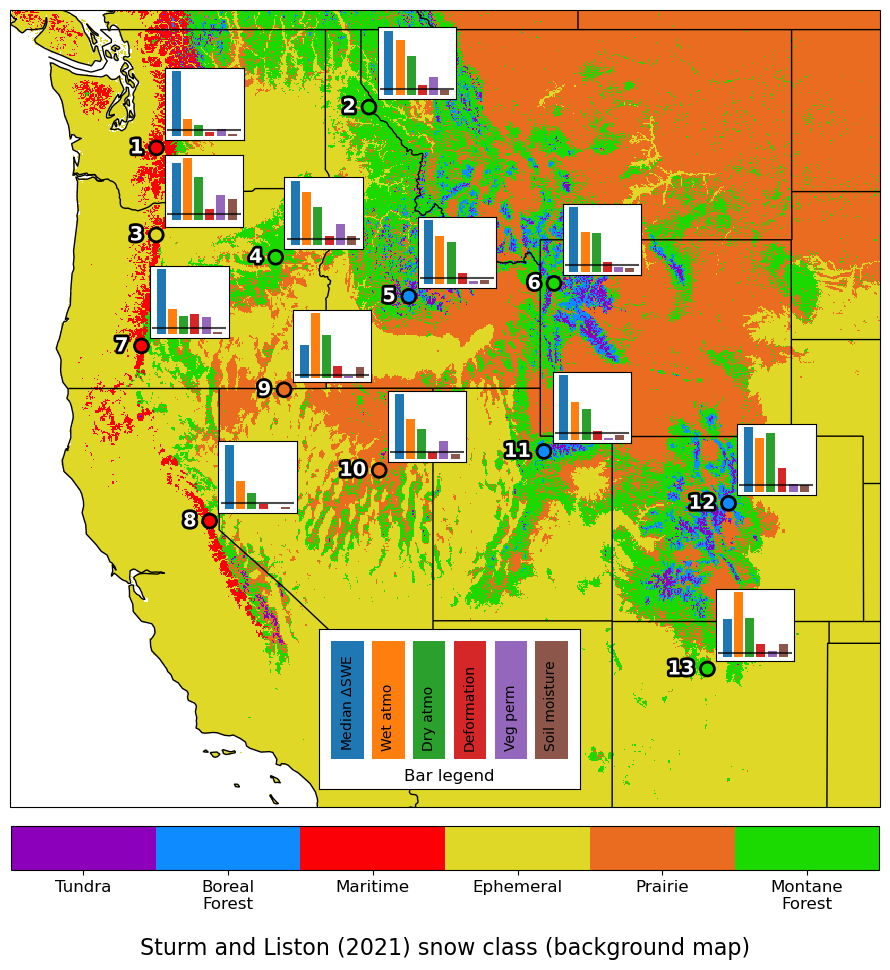

In [14]:
# sites = gpd.read_file('/pl/active/palomaki-sar/insar_swe_errors/data/snotel/fig4_sites.csv', geometry='geometry')
sites = gpd.read_file('local/median_errors_accum_only.csv')
# sites = gpd.read_file('local/median_errors_accum_only_nonabs.csv')
sites['ecoregion'].replace('', np.nan, inplace=True)
sites.dropna(subset='ecoregion', inplace=True)
sites['map_number'] = [1,3,7,8,4,9,10,2,5,6,11,12,13]
for c in sites.columns:
    try:
        sites[c] = pd.to_numeric(sites[c])
    except:
        continue
        
sites['geometry'] = gpd.points_from_xy(sites['lon'], sites['lat'], crs='epsg:4326')
sites = gpd.GeoDataFrame(sites).to_crs('epsg:3857')
sites = sites.loc[sites['ecoregion']!='']

countries = cfeature.NaturalEarthFeature(
        category='cultural',
        name='admin_0_boundary_lines_land',
        scale='10m',
        facecolor='none')

states_provinces = cfeature.NaturalEarthFeature(
        category='cultural',
        name='admin_1_states_provinces_lines',
        scale='10m',
        facecolor='none')

fig = plt.figure(figsize=(10,10))
ax = plt.axes(projection=ccrs.epsg(3857))
ax.coastlines()
# ax.
ax.add_feature(countries)
ax.add_feature(states_provinces)
minx, miny, maxx, maxy = sites.total_bounds
minx *= 1.03
maxx *= 0.96
miny *= 0.9
maxy *= 1.05
ax.set_extent((minx, maxx, miny, maxy), crs=ccrs.epsg(3857))

color_dict = {1:'#8d00bb',2:'#0e8bff',3:'#fb0006',4:'#dfd826',5:'#e96c20',6:'#1bda02',7:'#9a9a9a'}
sturm_colors_sites = [color_dict[x] for x in sites['sturm']]
sites['sturm_colors'] = sturm_colors_sites

sturm_colors = list(color_dict.values())[:-1]
sturm_cmap = mcolors.ListedColormap(sturm_colors)
bounds = np.arange(1,8)
sturm_norm = mcolors.BoundaryNorm(bounds, sturm_cmap.N)

sites['geometry'].plot(ax=ax, color=sites['sturm_colors'], markersize=100, edgecolor='k', linewidth=2, zorder=100)

sites['ax_x'] = (sites['geometry'].x - minx) / (maxx-minx)
sites['ax_y'] = (sites['geometry'].y - miny) / (maxy-miny)
colors = [plt.get_cmap('tab10')(i) for i in range(7)]
colors_non_ion = [plt.get_cmap('tab10')(i) for i in range(6)]

rel_error_df = pd.DataFrame(columns=['median_swe_change','median_ion_error','median_wet_error','median_dry_error','median_defo_error','median_veg_error','median_soil_error'],
                           index=sites['station_name'])
# rel_error_std_df = pd.DataFrame(columns=['std_swe_change','std_ion_error','std_wet_error','std_dry_error','std_defo_error','std_veg_error','std_soil_error'],
#                            index=sites['station_name'])

for i, site in sites.iterrows():
    rel_errors = site[['median_swe_change','median_ion_error','median_wet_error','median_dry_error','median_defo_error','median_veg_error','median_soil_error']]/site['median_swe_change']
    rel_error_df.loc[site['station_name']] = rel_errors * 100
    rel_error_df.loc[site['station_name'], 'median_swe_change'] = site['median_swe_change']
    rel_errors.drop('median_ion_error', inplace=True)
    # Add standard deviations
#     rel_errors_std = site[['std_swe_change','std_ion_error','std_wet_error','std_dry_error','std_defo_error','std_veg_error','std_soil_error']]/site['median_swe_change']
#     rel_error_std_df.loc[site['station_name']] = rel_errors_std * 100
#     rel_error_std_df.loc[site['station_name'], 'median_swe_change'] = site['median_swe_change']
#     rel_errors_std.drop('std_ion_error', inplace=True)
    ax_mini = ax.inset_axes([site['ax_x']+0.01, site['ax_y']+0.01, 0.09, 0.09], transform=ax.transAxes)
    ax_mini.patch.set_alpha(1.0)
    ax_mini.spines[['top','right','left']].set_visible(True)
    ax_mini.bar(np.arange(6), rel_errors, color=colors_non_ion)
#     ax_mini.bar(np.arange(6), rel_errors, color=colors_non_ion, yerr=rel_errors_std)
    ax_mini.hlines(0.1, -0.8, 5.8, lw=1.5, color='k', ls='-', alpha=0.7)
    ax_mini.tick_params(axis='both', labelbottom=False, labelleft=False, bottom=False, left=False)
    ax_mini.text(site['ax_x']-0.015, site['ax_y'], site['map_number'], color='white', fontsize=14, weight='bold', ha='right', va='center', transform=ax.transAxes,  path_effects=[pe.withStroke(linewidth=4, foreground='black')])
    if rel_errors.max() <= 1:
        ymin = -0.06
    else:
        ymin = -0.12
    ax_mini.set_ylim(ymin, ax_mini.get_ylim()[1])
    ax_mini.set_xlim(-1, 6)
                            
# ax_legend = ax.inset_axes([0.66, 0.75, 0.3, 0.2], transform=ax.transAxes) # Upper right
ax_legend = ax.inset_axes([0.355, 0.023, 0.3, 0.2], transform=ax.transAxes)
ax_legend.patch.set_alpha(1.0)
# ax_legend.patch.set_alpha(0.0)
ax_legend.spines[['top','right','left','bottom']].set_visible(True)
ax_legend.bar(np.arange(6), np.tile(1,6), color=colors_non_ion)
# ax_legend.text(0.5, 1, 'Legend', ha='center', transform=ax_legend.transAxes)
ax_legend.text(0.5, 0.05, 'Bar legend', fontsize=12, ha='center', transform=ax_legend.transAxes)
ax_legend.set_ylim(-0.25, 1.1)
ax_legend.tick_params(axis='both', labelbottom=False, labelleft=False, bottom=False, left=False)
for i, text in enumerate(['Median $\Delta$SWE','Wet atmo','Dry atmo','Deformation','Veg perm','Soil moisture']):
    ax_legend.text(i-0.18, 0.1, text, rotation=90)
    
sturm = rxr.open_rasterio('/pl/active/palomaki-sar/insar_swe_errors/data/ancillary/SnowClass_NA_300m_10.0arcsec_2021_v01.0.tif').rio.reproject('epsg:3857').rio.clip_box(minx, miny, maxx, maxy)
sturm = sturm.where(sturm<8)
mesh = sturm.plot(ax=ax, zorder=0, cmap=sturm_cmap, norm=sturm_norm, add_colorbar=False)
cbar = plt.colorbar(mesh, orientation='horizontal', shrink=0.895, pad=0.02)
cbar.ax.xaxis.set_ticks(np.arange(1.5,7,1), labels=['Tundra','Boreal\nForest','Maritime','Ephemeral','Prairie','Montane\nForest'])
cbar.ax.set_xlabel('Sturm and Liston (2021) snow class (background map)', labelpad=18, fontsize=16)
cbar.ax.tick_params(axis='x', which='major', labelsize=12)
cbar.ax.tick_params(axis='x', which='minor', bottom=False)
ax.set_title('')

plt.tight_layout()
# fig.savefig('local/figs/fig4.png', dpi=300)

## New version of map figure without taking abs of error components

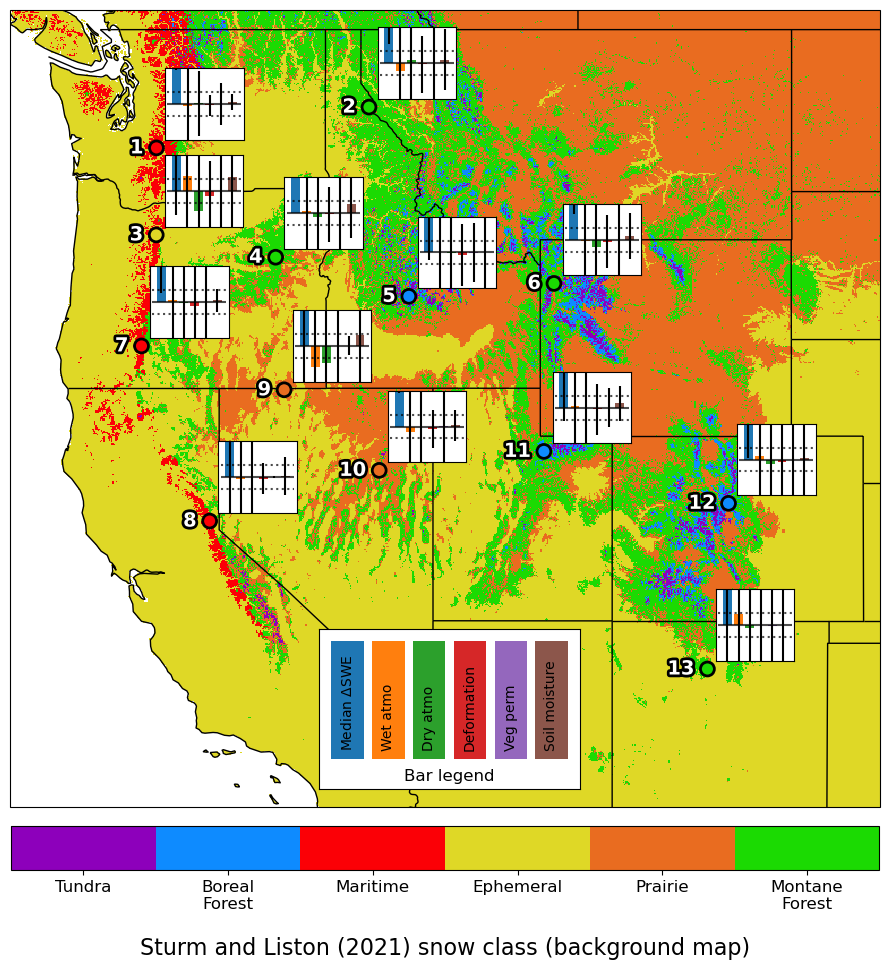

In [18]:
# sites = gpd.read_file('/pl/active/palomaki-sar/insar_swe_errors/data/snotel/fig4_sites.csv', geometry='geometry')
# sites = gpd.read_file('local/median_errors_accum_only.csv')
sites = gpd.read_file('local/median_errors_accum_only_nonabs.csv')
sites['ecoregion'].replace('', np.nan, inplace=True)
sites.dropna(subset='ecoregion', inplace=True)
sites['map_number'] = [1,3,7,8,4,9,10,2,5,6,11,12,13]
for c in sites.columns:
    try:
        sites[c] = pd.to_numeric(sites[c])
    except:
        continue
        
sites['geometry'] = gpd.points_from_xy(sites['lon'], sites['lat'], crs='epsg:4326')
sites = gpd.GeoDataFrame(sites).to_crs('epsg:3857')
sites = sites.loc[sites['ecoregion']!='']

countries = cfeature.NaturalEarthFeature(
        category='cultural',
        name='admin_0_boundary_lines_land',
        scale='10m',
        facecolor='none')

states_provinces = cfeature.NaturalEarthFeature(
        category='cultural',
        name='admin_1_states_provinces_lines',
        scale='10m',
        facecolor='none')

fig = plt.figure(figsize=(10,10))
ax = plt.axes(projection=ccrs.epsg(3857))
ax.coastlines()
# ax.
ax.add_feature(countries)
ax.add_feature(states_provinces)
minx, miny, maxx, maxy = sites.total_bounds
minx *= 1.03
maxx *= 0.96
miny *= 0.9
maxy *= 1.05
ax.set_extent((minx, maxx, miny, maxy), crs=ccrs.epsg(3857))

color_dict = {1:'#8d00bb',2:'#0e8bff',3:'#fb0006',4:'#dfd826',5:'#e96c20',6:'#1bda02',7:'#9a9a9a'}
sturm_colors_sites = [color_dict[x] for x in sites['sturm']]
sites['sturm_colors'] = sturm_colors_sites

sturm_colors = list(color_dict.values())[:-1]
sturm_cmap = mcolors.ListedColormap(sturm_colors)
bounds = np.arange(1,8)
sturm_norm = mcolors.BoundaryNorm(bounds, sturm_cmap.N)

sites['geometry'].plot(ax=ax, color=sites['sturm_colors'], markersize=100, edgecolor='k', linewidth=2, zorder=100)

sites['ax_x'] = (sites['geometry'].x - minx) / (maxx-minx)
sites['ax_y'] = (sites['geometry'].y - miny) / (maxy-miny)
colors = [plt.get_cmap('tab10')(i) for i in range(7)]
colors_non_ion = [plt.get_cmap('tab10')(i) for i in range(6)]

rel_error_df = pd.DataFrame(columns=['median_swe_change','median_ion_error','median_wet_error','median_dry_error','median_defo_error','median_veg_error','median_soil_error'],
                           index=sites['station_name'])
rel_error_std_df = pd.DataFrame(columns=['std_swe_change','std_ion_error','std_wet_error','std_dry_error','std_defo_error','std_veg_error','std_soil_error'],
                           index=sites['station_name'])

for i, site in sites.iterrows():
    rel_errors = site[['median_swe_change','median_ion_error','median_wet_error','median_dry_error','median_defo_error','median_veg_error','median_soil_error']]/site['median_swe_change']
    rel_error_df.loc[site['station_name']] = rel_errors * 100
    rel_error_df.loc[site['station_name'], 'median_swe_change'] = site['median_swe_change']
    rel_errors.drop('median_ion_error', inplace=True)
    # Add standard deviations
    rel_errors_std = site[['std_swe_change','std_ion_error','std_wet_error','std_dry_error','std_defo_error','std_veg_error','std_soil_error']]/site['median_swe_change']
    rel_error_std_df.loc[site['station_name']] = rel_errors_std * 100
    rel_error_std_df.loc[site['station_name'], 'median_swe_change'] = site['median_swe_change']
    rel_errors_std.drop('std_ion_error', inplace=True)
    ax_mini = ax.inset_axes([site['ax_x']+0.01, site['ax_y']+0.01, 0.09, 0.09], transform=ax.transAxes)
    ax_mini.patch.set_alpha(1.0)
    ax_mini.spines[['top','right','left']].set_visible(True)
#     ax_mini.bar(np.arange(6), rel_errors, color=colors_non_ion)
    ax_mini.bar(np.arange(6), rel_errors, color=colors_non_ion, yerr=rel_errors_std)
    ax_mini.hlines(0.0, -0.8, 5.8, lw=1.5, color='k', ls='-', alpha=0.7)
    ax_mini.hlines((-0.1,0.1), -0.8, 5.8, lw=1.5, color='k', ls=':', alpha=0.7)
    ax_mini.tick_params(axis='both', labelbottom=False, labelleft=False, bottom=False, left=False)
    ax_mini.text(site['ax_x']-0.015, site['ax_y'], site['map_number'], color='white', fontsize=14, weight='bold', ha='right', va='center', transform=ax.transAxes,  path_effects=[pe.withStroke(linewidth=4, foreground='black')])
#     if rel_errors.max() <= 1:
#         ymin = -0.06
#     else:
#         ymin = -0.12
#     ax_mini.set_ylim(ymin, ax_mini.get_ylim()[1])
    ax_mini.set_ylim(-0.3, 0.3)
    ax_mini.set_xlim(-1, 6)
                            
# ax_legend = ax.inset_axes([0.66, 0.75, 0.3, 0.2], transform=ax.transAxes) # Upper right
ax_legend = ax.inset_axes([0.355, 0.023, 0.3, 0.2], transform=ax.transAxes)
ax_legend.patch.set_alpha(1.0)
# ax_legend.patch.set_alpha(0.0)
ax_legend.spines[['top','right','left','bottom']].set_visible(True)
ax_legend.bar(np.arange(6), np.tile(1,6), color=colors_non_ion)
# ax_legend.text(0.5, 1, 'Legend', ha='center', transform=ax_legend.transAxes)
ax_legend.text(0.5, 0.05, 'Bar legend', fontsize=12, ha='center', transform=ax_legend.transAxes)
ax_legend.set_ylim(-0.25, 1.1)
ax_legend.tick_params(axis='both', labelbottom=False, labelleft=False, bottom=False, left=False)
for i, text in enumerate(['Median $\Delta$SWE','Wet atmo','Dry atmo','Deformation','Veg perm','Soil moisture']):
    ax_legend.text(i-0.18, 0.1, text, rotation=90)
    
sturm = rxr.open_rasterio('/pl/active/palomaki-sar/insar_swe_errors/data/ancillary/SnowClass_NA_300m_10.0arcsec_2021_v01.0.tif').rio.reproject('epsg:3857').rio.clip_box(minx, miny, maxx, maxy)
sturm = sturm.where(sturm<8)
mesh = sturm.plot(ax=ax, zorder=0, cmap=sturm_cmap, norm=sturm_norm, add_colorbar=False)
cbar = plt.colorbar(mesh, orientation='horizontal', shrink=0.895, pad=0.02)
cbar.ax.xaxis.set_ticks(np.arange(1.5,7,1), labels=['Tundra','Boreal\nForest','Maritime','Ephemeral','Prairie','Montane\nForest'])
cbar.ax.set_xlabel('Sturm and Liston (2021) snow class (background map)', labelpad=18, fontsize=16)
cbar.ax.tick_params(axis='x', which='major', labelsize=12)
cbar.ax.tick_params(axis='x', which='minor', bottom=False)
ax.set_title('')

plt.tight_layout()
# fig.savefig('local/figs/fig4.png', dpi=300)

In [38]:
rel_error_df.rename(columns={'median_swe_change':'Median $\Delta$SWE [m]','median_wet_error':'Wet atmosphere',
                             'median_dry_error':'Dry atmosphere','median_defo_error':'Deformation',
                             'median_veg_error':'Vegetation permittivity','median_soil_error':'Soil moisture',
                             'median_ion_error':'Ionosphere'}, inplace=True)
for c in rel_error_df.columns:
    if 'Median' not in c:
#         rel_error_df[c] *= 100
        rel_error_df[c] = rel_error_df[c].astype(float).round(1)
    else:
        rel_error_df[c] = rel_error_df[c].astype(float).round(3)
rel_error_df

error_df = pd.concat([rel_error_df[c]*rel_error_df['Median $\\Delta$SWE [m]']/100 for c in rel_error_df.columns[1:]], axis=1)
error_df.columns = rel_error_df.columns[1:]
error_df[[ 'Wet atmosphere', 'Dry atmosphere', 'Deformation',
       'Vegetation permittivity', 'Soil moisture', 'Ionosphere']].astype(float).round(3)

,Wet atmosphere,Dry atmosphere,Deformation,Vegetation permittivity,Soil moisture,Ionosphere
station_name,,,,,,
Paradise,0.030,0.020,0.006,0.012,0.004,0.166
Clackamas Lake,0.030,0.021,0.006,0.012,0.010,0.192
Annie Springs,0.025,0.019,0.020,0.017,0.002,0.217
Palisades Tahoe,0.022,0.013,0.004,0.000,0.002,0.242
Tipton,0.026,0.019,0.005,0.010,0.005,0.193
Disaster Peak,0.026,0.017,0.005,0.001,0.005,0.248
Corral Canyon,0.023,0.017,0.004,0.010,0.002,0.227
Sunset,0.025,0.018,0.005,0.008,0.003,0.163
Galena Summit,0.021,0.018,0.005,0.001,0.002,0.192


In [37]:
error_df.columns

Index(['Ionosphere', 'Wet atmosphere', 'Dry atmosphere', 'Deformation',
       'Vegetation permittivity', 'Soil moisture'],
      dtype='object')

<BarContainer object of 3 artists>

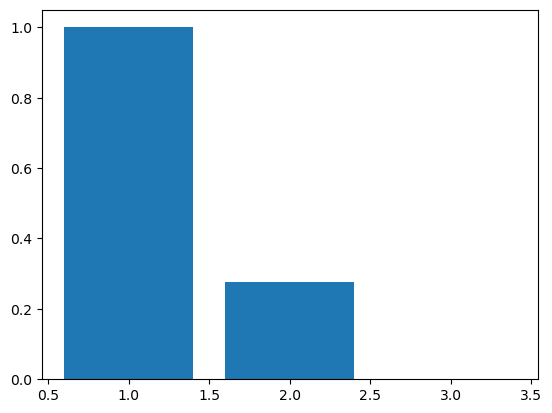

In [127]:
rel_error = pd.DataFrame(sites['median_peak_swe'] / sites['median_peak_swe'])
rel_error['soil_error'] = sites['soil_error'] / sites['median_peak_swe']
rel_error['veg_error'] = sites['veg_error'] / sites['median_peak_swe']

fig.add_axes([l, b, w, h])

fig, ax = plt.subplots()
ax.bar([1,2,3], rel_error.loc[12])

In [126]:
rel_error

0                                                           1.0
1                                                           1.0
2                                                           1.0
3                                                           1.0
4                                                           1.0
5                                                           1.0
6                                                           1.0
7                                                           1.0
8                                                           1.0
9                                                           1.0
10                                                          1.0
11                                                          1.0
12                                                          1.0
soil_error    0     0.025407
1     0.103637
2     0.051172
3...
veg_error     0     0.002518
1     0.000075
2     0.000000
3...
Name: median_peak_swe, dtype: object

In [122]:
sites['median_peak_swe']

0     2.09042
1     0.37338
2     1.10236
3     0.42926
4     0.35306
5     0.45720
6     0.54610
7     0.51308
8     0.54610
9     0.83820
10    0.66294
11    0.30480
12    0.18796
Name: median_peak_swe, dtype: float64

In [18]:
station_id = '653_OR_SNTL'
test = pd.read_csv(f'https://raw.githubusercontent.com/egagli/snotel_ccss_stations/main/data/{station_id}.csv',index_col='datetime', parse_dates=True)
test

,TAVG,TMIN,TMAX,SNWD,WTEQ,PRCPSA
datetime,,,,,,
1980-10-01,NaN,NaN,NaN,NaN,0.0,0.0102
1980-10-02,NaN,NaN,NaN,NaN,0.0,0.0000
1980-10-03,NaN,NaN,NaN,NaN,0.0,0.0000
1980-10-04,NaN,NaN,NaN,NaN,0.0,0.0000
1980-10-05,NaN,NaN,NaN,NaN,0.0,0.0000
...,...,...,...,...,...,...
2025-07-05,6.2,3.4,8.6,0.0000,0.0,0.0025
2025-07-06,6.1,1.9,11.6,0.0000,0.0,0.0051
2025-07-07,10.2,3.2,17.9,0.0000,0.0,0.0000
